In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataset import Subset
import numpy as np



### Load CIFAR10 training and test datasets


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:01<00:00, 88592143.21it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Split training data into train and validation sets


In [ ]:
# Load CIFAR10 training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_size = int(0.8 * len(trainset))
validation_size = len(trainset) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(trainset, [train_size, validation_size])

### Data loaders for training, validation, and test


In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


### Model

In [5]:
import torchvision.models as models

resnet18 = models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, 10)  # Adjusting for CIFAR10's 10 classes


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 85.3MB/s]


###optimizer

In [6]:
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)

###Define Circle Loss

In [7]:
from typing import Tuple

import torch
from torch import nn, Tensor


def convert_label_to_similarity(normed_feature: Tensor, label: Tensor) -> Tuple[Tensor, Tensor]:
    similarity_matrix = normed_feature @ normed_feature.transpose(1, 0)
    label_matrix = label.unsqueeze(1) == label.unsqueeze(0)

    positive_matrix = label_matrix.triu(diagonal=1)
    negative_matrix = label_matrix.logical_not().triu(diagonal=1)

    similarity_matrix = similarity_matrix.view(-1)
    positive_matrix = positive_matrix.view(-1)
    negative_matrix = negative_matrix.view(-1)
    return similarity_matrix[positive_matrix], similarity_matrix[negative_matrix]


class CircleLoss(nn.Module):
    def __init__(self, m: float, gamma: float) -> None:
        super(CircleLoss, self).__init__()
        self.m = m
        self.gamma = gamma
        self.soft_plus = nn.Softplus()

    def forward(self, sp: Tensor, sn: Tensor) -> Tensor:
        ap = torch.clamp_min(- sp.detach() + 1 + self.m, min=0.)
        an = torch.clamp_min(sn.detach() + self.m, min=0.)

        delta_p = 1 - self.m
        delta_n = self.m

        logit_p = - ap * (sp - delta_p) * self.gamma
        logit_n = an * (sn - delta_n) * self.gamma

        loss = self.soft_plus(torch.logsumexp(logit_n, dim=0) + torch.logsumexp(logit_p, dim=0))

        return loss


### Model training

Epoch 1, Train Loss: 42.3042, Val Loss: 39.3822
Epoch 2, Train Loss: 38.7956, Val Loss: 38.8071
Epoch 3, Train Loss: 38.2144, Val Loss: 38.4477
Epoch 4, Train Loss: 37.8886, Val Loss: 38.2275
Epoch 5, Train Loss: 37.7772, Val Loss: 38.2361
Epoch 6, Train Loss: 37.6639, Val Loss: 38.2718
Epoch 7, Train Loss: 37.5652, Val Loss: 38.5305
Epoch 8, Train Loss: 37.5447, Val Loss: 38.3811
Epoch 9, Train Loss: 37.5315, Val Loss: 38.0824
Epoch 10, Train Loss: 37.4845, Val Loss: 38.1519
Epoch 11, Train Loss: 37.3864, Val Loss: 38.1166
Epoch 12, Train Loss: 37.3100, Val Loss: 38.0695
Epoch 13, Train Loss: 37.2368, Val Loss: 38.1300
Epoch 14, Train Loss: 37.1988, Val Loss: 37.9086
Epoch 15, Train Loss: 37.0816, Val Loss: 37.9376
Epoch 16, Train Loss: 37.0060, Val Loss: 37.9267
Epoch 17, Train Loss: 36.8812, Val Loss: 38.0605
Epoch 18, Train Loss: 36.7485, Val Loss: 37.7353
Epoch 19, Train Loss: 36.7048, Val Loss: 37.6068
Epoch 20, Train Loss: 36.5541, Val Loss: 37.6721
Epoch 21, Train Loss: 36.5201

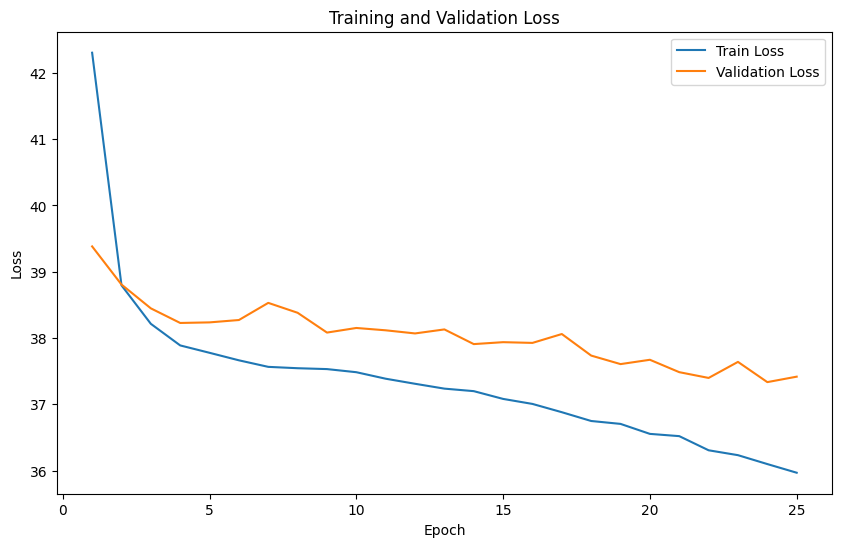

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataset import Subset
import matplotlib.pyplot as plt
from torch import nn

# Initial settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 25
train_losses = []
val_losses = []

circle_loss = CircleLoss(m=0.5, gamma=64).to(device)

# Setting up the model and optimizer
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, 10)  # Adjusting for CIFAR10's 10 classes
resnet18 = resnet18.to(device)
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    resnet18.train()
    running_loss_train = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = resnet18(inputs)
        normed_features = nn.functional.normalize(outputs, dim=1)
        sp, sn = convert_label_to_similarity(normed_features, labels)
        loss = circle_loss(sp, sn)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item()
    avg_train_loss = running_loss_train / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation of the model on validation data
    resnet18.eval()
    running_loss_val = 0.0
    with torch.no_grad():
        for i, data in enumerate(validation_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = resnet18(inputs)
            normed_features = nn.functional.normalize(outputs, dim=1)
            sp, sn = convert_label_to_similarity(normed_features, labels)
            loss = circle_loss(sp, sn)
            running_loss_val += loss.item()
    avg_val_loss = running_loss_val / len(validation_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [9]:
# Removing the final classification layer
feature_extractor = torch.nn.Sequential(*list(resnet18.children())[:-1])
feature_extractor = feature_extractor.to(device)

In [10]:
def extract_features(dataloader):
    features = []
    labels = []

    feature_extractor.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs, lbls = data[0].to(device), data[1].to(device)
            output = feature_extractor(inputs)
            features.extend(output.view(output.size(0), -1).cpu().numpy())
            labels.extend(lbls.cpu().numpy())

    return np.array(features), np.array(labels)

# Extracting features
train_features, train_labels = extract_features(train_loader)
test_features, test_labels = extract_features(test_loader)


### Training the KNN classifier

In [27]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_features, train_labels)


KNeighborsClassifier()

### Evaluating the KNN classifier

In [35]:
accuracy = knn.score(test_features, test_labels)
print(f'Accuracy of KNN classifier on test set: {accuracy*100:.2f}%')


Accuracy of KNN classifier on test set: 77.64%


In [ ]:
! pip install umap-learn


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


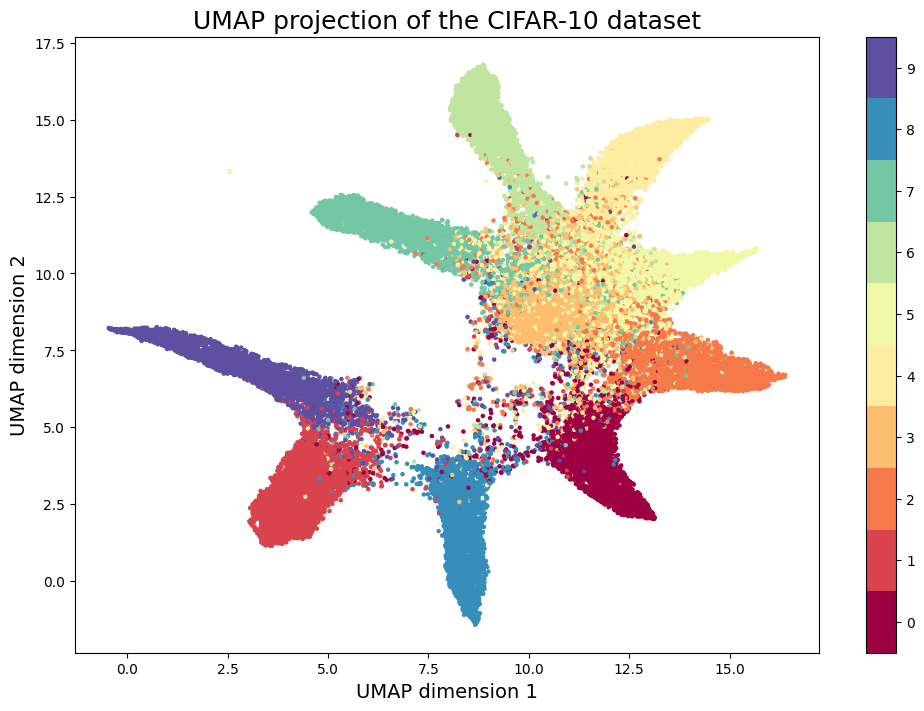

In [21]:
import umap
import matplotlib.pyplot as plt

# Using UMAP to reduce the dimensionality of features to two dimensions
reducer = umap.UMAP(random_state=42)
umap_embedding = reducer.fit_transform(train_features)

# Visualizing the results
plt.figure(figsize=(12, 8))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=train_labels, cmap='Spectral', s=5)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the CIFAR-10 dataset', fontsize=18)
plt.xlabel('UMAP dimension 1', fontsize=14)
plt.ylabel('UMAP dimension 2', fontsize=14)
plt.show()


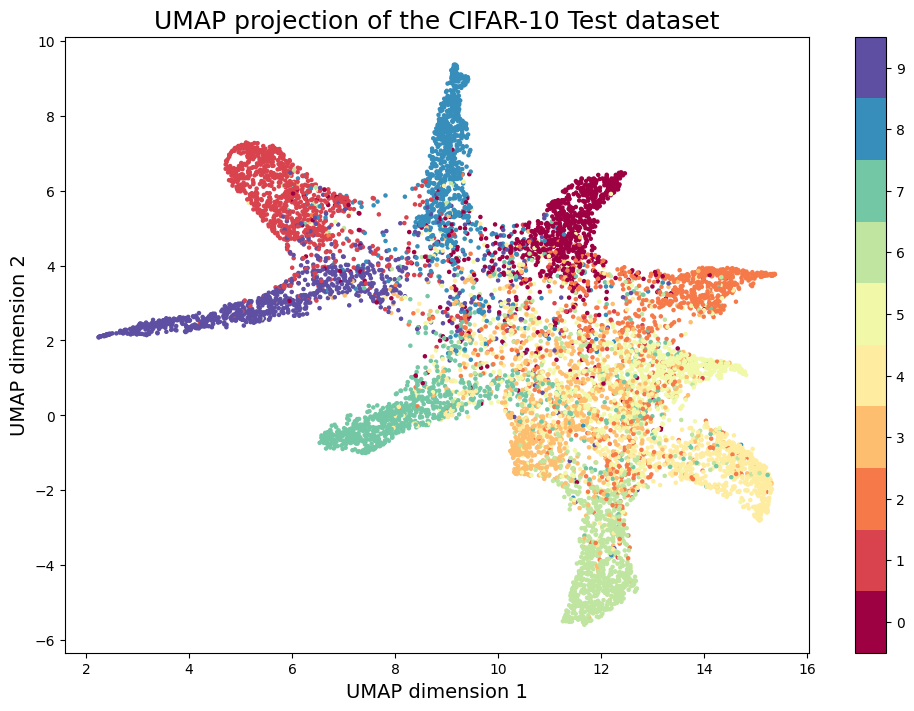

In [18]:
# Extracting features for test data
test_features, test_labels = extract_features(test_loader)

# Using UMAP to reduce the dimensionality of features to two dimensions for test data
umap_embedding_test = reducer.fit_transform(test_features)

# Visualizing the results for test data
plt.figure(figsize=(12, 8))
plt.scatter(umap_embedding_test[:, 0], umap_embedding_test[:, 1], c=test_labels, cmap='Spectral', s=5)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the CIFAR-10 Test dataset', fontsize=18)
plt.xlabel('UMAP dimension 1', fontsize=14)
plt.ylabel('UMAP dimension 2', fontsize=14)
plt.show()


In [22]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image


In [36]:
# Function to add random noise to an image
def add_random_noise(image, noise_level=0.1):
    noise = torch.randn_like(image) * noise_level
    noisy_image = image + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)  # keep pixel values in [0,1]
    return noisy_image


In [23]:
def generate_and_extract_features(model, device, data_loader, epsilon, feature_extractor):
    model.eval()
    feature_extractor.eval()
    adv_features = []
    adv_labels = []

    for data, target in data_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        loss = F.cross_entropy(output, target)  # Using Cross Entropy for gradient calculation
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        perturbed_data = perturbed_data.detach()
        output = feature_extractor(perturbed_data)
        adv_features.extend(output.view(output.size(0), -1).cpu().detach().numpy())
        adv_labels.extend(target.cpu().numpy())

    return np.array(adv_features), np.array(adv_labels)



In [30]:
import torch.nn.functional as F

# Initialization
epsilon = 0.1  # Amount of noise added to the data

# Generating adversarial samples and extracting features
adv_features, adv_labels = generate_and_extract_features(resnet18, device, test_loader, epsilon, feature_extractor)

# Evaluating with KNN classifier
knn_accuracy = knn.score(adv_features, adv_labels)
print(f'Accuracy of KNN on adversarial examples: {knn_accuracy*100:.2f}%')


Accuracy of KNN on adversarial examples: 52.24%


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


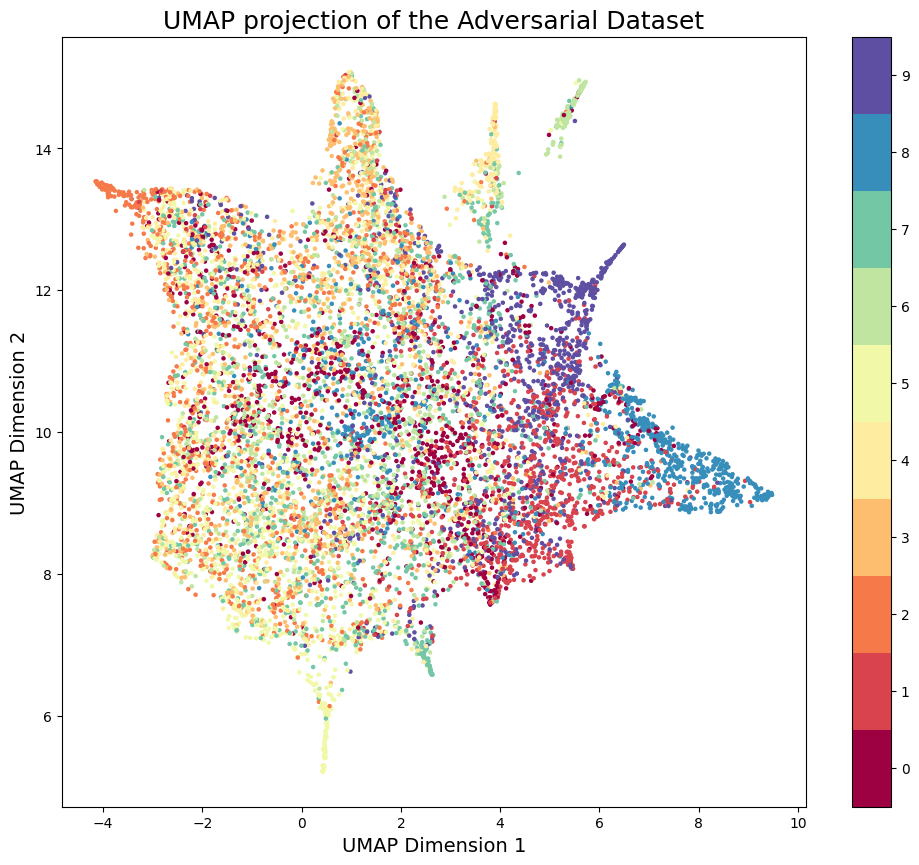

In [31]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# Defining and training UMAP model on the extracted features from adversarial data
reducer = umap.UMAP(random_state=42)
umap_embedding = reducer.fit_transform(adv_features)

# Plotting scatter plot using UMAP results
plt.figure(figsize=(12, 10))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=adv_labels, cmap='Spectral', s=5)
plt.colorbar(boundaries=np.arange(len(np.unique(adv_labels))+1)-0.5).set_ticks(np.arange(len(np.unique(adv_labels))))
plt.title('UMAP projection of the Adversarial Dataset', fontsize=18)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.show()
